In [1]:
import numpy as np
import pandas as pd

import csv as csv
import zipfile

all_train = pd.read_csv('/nfs/science/shared/ipythonNotebooks/anantk/Kgl/alls/train.csv.zip',  header=0, sep=',')
print(all_train.head())

all_test = pd.read_csv('/nfs/science/shared/ipythonNotebooks/anantk/Kgl/alls/test.csv.zip',  header=0, sep=',')
print(all_test.head())


import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.cross_validation import KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

ID = 'id'
TARGET = 'loss'
NFOLDS = 4
SEED = 0
NROWS = None
DATA_DIR = "../input"

# TRAIN_FILE = "{0}/train.csv".format(DATA_DIR)
# TEST_FILE = "{0}/test.csv".format(DATA_DIR)
# SUBMISSION_FILE = "{0}/sample_submission.csv".format(DATA_DIR)

# train = pd.read_csv(TRAIN_FILE, nrows=NROWS)
# test = pd.read_csv(TEST_FILE, nrows=NROWS)

y_train = all_train[TARGET].ravel()

all_train.drop([ID, TARGET], axis=1, inplace=True)
all_test.drop([ID], axis=1, inplace=True)

print("{},{}".format(all_train.shape, all_test.shape))

ntrain = all_train.shape[0]
ntest = all_test.shape[0]
train_test = pd.concat((all_train, all_test)).reset_index(drop=True)

features = all_train.columns

cats = [feat for feat in features if 'cat' in feat]
for feat in cats:
    train_test[feat] = pd.factorize(train_test[feat], sort=True)[0]
# for feat in cats:
#     train_test[feat] = pd.get_dummies(train_test[feat])

print(train_test.head())



   id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9   ...        cont6  \
0   1    A    B    A    B    A    A    A    A    B   ...     0.718367   
1   2    A    B    A    A    A    A    A    A    B   ...     0.438917   
2   5    A    B    A    A    B    A    A    A    B   ...     0.289648   
3  10    B    B    A    B    A    A    A    A    B   ...     0.440945   
4  11    A    B    A    B    A    A    A    A    B   ...     0.178193   

      cont7    cont8    cont9   cont10    cont11    cont12    cont13  \
0  0.335060  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493   
1  0.436585  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431   
2  0.315545  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709   
3  0.391128  0.31796  0.32128  0.44467  0.327915  0.321570  0.605077   
4  0.247408  0.24564  0.22089  0.21230  0.204687  0.202213  0.246011   

     cont14     loss  
0  0.714843  2213.18  
1  0.304496  1283.60  
2  0.774425  3005.09  
3  0.602642   939.85  
4  0.432606  

/usr/lib64/python2.7/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:28: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(188318, 130),(125546, 130)
   cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9  cat10    ...     \
0     0     1     0     1     0     0     0     0     1      0    ...      
1     0     1     0     0     0     0     0     0     1      1    ...      
2     0     1     0     0     1     0     0     0     1      1    ...      
3     1     1     0     1     0     0     0     0     1      0    ...      
4     0     1     0     1     0     0     0     0     1      1    ...      

      cont5     cont6     cont7    cont8    cont9   cont10    cont11  \
0  0.310061  0.718367  0.335060  0.30260  0.67135  0.83510  0.569745   
1  0.885834  0.438917  0.436585  0.60087  0.35127  0.43919  0.338312   
2  0.397069  0.289648  0.315545  0.27320  0.26076  0.32446  0.381398   
3  0.422268  0.440945  0.391128  0.31796  0.32128  0.44467  0.327915   
4  0.704268  0.178193  0.247408  0.24564  0.22089  0.21230  0.204687   

     cont12    cont13    cont14  
0  0.594646  0.822493  0.714843  
1  0.366307  0

In [3]:
from scipy.stats import skew, boxcox

numeric_feats = all_train.dtypes[all_train.dtypes != "object"].index
numeric_feats

skewed_feats =  all_train[numeric_feats].apply(lambda x: skew(x.dropna()))
print("\nSkew in numeric features:")
print(skewed_feats)
    # transform features with skew > 0.25 (this can be varied to find optimal value)
skewed_feats = skewed_feats[skewed_feats > 0.3]
skewed_feats = skewed_feats.index
for feats in skewed_feats:
    train_test[feats] = train_test[feats] + 1
    train_test[feats], lam = boxcox(train_test[feats])

x_train = np.array(train_test.iloc[:ntrain,:])
x_test = np.array(train_test.iloc[ntrain:,:])


X_train = pd.DataFrame(x_train)
X_test = pd.DataFrame(x_test)

X_train.columns = all_train.columns
X_test.columns = all_train.columns


# from scipy.interpolate import Rbf
# from sklearn.kernel_approximation import RBFSampler
# from sklearn.linear_model import SGDClassifier
# rbf_feature = RBFSampler(gamma=1, random_state=1)

# def basis_exp(df,variables):
#     for i,var_name in enumerate(variables):
#         for i in range(2,5):  # power of 1 is already there
#             colname = var_name+'_%d'%i      # new var will be x_power
#             df[colname] = df[var_name]**i
#         col_log_name = var_name +'_log'
#         df[col_log_name] = np.log(df[var_name] + 1)
#         col_sq = var_name +'_sq'
#         df[col_sq] = np.sqrt(df[var_name])
        

# basis_exp(X_train,numeric_feats)
# basis_exp(X_test,numeric_feats)

# skewed_feats =  X_train[numeric_feats].apply(lambda x: skew(x.dropna()))
#     print("\nSkew in numeric features:")
#     print(skewed_feats)
#     # transform features with skew > 0.25 (this can be varied to find optimal value)
#     skewed_feats = skewed_feats[skewed_feats > 0.25]
#     skewed_feats = skewed_feats.index
#     for feats in skewed_feats:
#         train_test[feats] = train_test[feats] + 1
#         train_test[feats], lam = boxcox(train_test[feats])
        
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(interaction_only=True)

# x_tr = poly.fit_transform(X_train)
# x_ts = poly.fit_transform(X_test)

# x_tr = rbf_feature.fit_transform(X_train)
# x_test = rbf_feature.fit_transform(X_test)

X_train = scale(X_train)
X_test = scale(X_test)


Skew in numeric features:
cont1     0.516420
cont2    -0.310939
cont3    -0.010002
cont4     0.416093
cont5     0.681617
cont6     0.461211
cont7     0.826046
cont8     0.676629
cont9     1.072420
cont10    0.354998
cont11    0.280819
cont12    0.291990
cont13    0.380739
cont14    0.248672
dtype: float64


In [25]:
X_train

array([[-0.57480358,  1.14363608, -0.24084829, ...,  0.57701629,
         1.37555807,  0.98489365],
       [-0.57480358,  1.14363608, -0.24084829, ..., -0.53348362,
         0.70702419, -0.85947072],
       [-0.57480358,  1.14363608, -0.24084829, ..., -0.49410817,
        -1.77040662,  1.25269362],
       ..., 
       [-0.57480358,  1.14363608, -0.24084829, ..., -0.12505174,
        -0.64674071,  0.03672567],
       [-0.57480358,  1.14363608, -0.24084829, ...,  1.5470456 ,
         0.86428049,  1.01574489],
       [ 1.73972473, -0.87440403, -0.24084829, ...,  1.84478553,
         1.34342414,  1.01463472]])

In [52]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss
from sklearn import preprocessing

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import sys
# The path to XGBoost wrappers goes here
# sys.path.append('C:\\Users\\Amine\\Documents\\GitHub\\xgboost\\wrapper')
import xgboost as xgb

def score(params):
    print "Training with params : "
    print params
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    # watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_round)
    predictions = model.predict(dvalid).reshape((X_test.shape[0], 9))
    score = log_loss(y_test, predictions)
    print "\tScore {0}\n\n".format(score)
    return {'loss': score, 'status': STATUS_OK}


def optimize(trials):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
             'max_depth' : hp.quniform('max_depth', 1, 13, 1),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             'num_class' : 9,
             'eval_metric': 'mlogloss',
             'objective': 'multi:softprob',
             'nthread' : 6,
             'silent' : 1
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=250)

    print best

array([[-0.57480358,  1.14363608, -0.24084829, ...,  0.70131077,
         0.99966361,  0.99892808],
       [-0.57480358,  1.14363608, -0.24084829, ..., -0.79042916,
        -0.85172136, -0.83645512],
       [-0.57480358,  1.14363608, -0.24084829, ...,  1.28353073,
         1.23086199,  1.21473449],
       ..., 
       [-0.57480358,  1.14363608, -0.24084829, ..., -0.46038726,
         0.11109707,  0.15125239],
       [-0.57480358,  1.14363608, -0.24084829, ...,  0.76141545,
         1.02670425,  1.02423661],
       [ 1.73972473, -0.87440403, -0.24084829, ...,  0.75922262,
         1.02573307,  1.02332798]])

In [ ]:
import time as time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.datasets import load_digits
from sklearn.grid_search import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import scale,StandardScaler

dtrain = xgb.DMatrix(X_train, label=np.log(y_train +220))

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.31,
    'silent': 1,
    'subsample': 0.99,
    'reg_alpha' : 2,
    'learning_rate': 0.1,
    'objective': 'reg:linear',
    'max_depth': 12,
    'num_parallel_tree': 4,
    'min_child_weight': 100,
    'eval_metric': 'mae',
#     'nthread' :-1,
    'gamma' : 5
}

res = xgb.cv(xgb_params, dtrain, num_boost_round=10000, nfold=10,seed=SEED, stratified=False,
             early_stopping_rounds=50, verbose_eval=10, show_stdv=True)


[0]	train-mae:6.57938+0.000554276	test-mae:6.57938+0.0054075


In [12]:
best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]

print('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std) + str(xgb_params))

gbdt = xgb.train(xgb_params, dtrain, best_nrounds)

dtest = xgb.DMatrix(X_test)
submission = pd.read_csv('/nfs/science/shared/ipythonNotebooks/anantk/Kgl/alls/sample_submission.csv(2).zip',header = 0)
submission.iloc[:, 1] = (np.exp(gbdt.predict(dtest)) - 220)
submission.to_csv('/nfs/science/shared/ipythonNotebooks/anantk/Kgl/alls/xg_new_5.csv', index=None)


Ensemble-CV: 0.3650614+0.00130158866006{'reg_alpha': 5, 'eval_metric': 'mae', 'learning_rate': 0.01, 'seed': 0, 'num_parallel_tree': 1, 'colsample_bytree': 0.31, 'silent': 1, 'min_child_weight': 4.2, 'subsample': 0.9, 'objective': 'reg:linear', 'max_depth': 12, 'gamma': 0.456}


In [10]:
sorted(["%s==%s" % (i.key, i.version) for i in pip.get_installed_distributions()])

NameError: name 'pip' is not defined

In [22]:
best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]

print('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std) + str(xgb_params))

# xgb_params = {
#     'seed': 0,
#     'colsample_bytree': 0.7,
#     'silent': 1,
#     'subsample': 0.6,
#     'reg_alpha' : 2.5,
#     'learning_rate': 0.05,
#     'objective': 'reg:linear',
#     'max_depth': 7,
#     'num_parallel_tree': 1,
#     'min_child_weight': 3,
#     'eval_metric': 'mae'
# }

# Ensemble-CV: 0.4147712+0.000882096910776

gbdt = xgb.train(xgb_params, dtrain, best_nrounds)

dtest = xgb.DMatrix(X_test)
submission = pd.read_csv('/nfs/science/shared/ipythonNotebooks/anantk/Kgl/alls/sample_submission.csv(2).zip',header = 0)
submission.iloc[:, 1] = np.exp(gbdt.predict(dtest))
submission.to_csv('/nfs/science/shared/ipythonNotebooks/anantk/Kgl/alls/xg_new_3.csv', index=None)


Ensemble-CV: 0.3782266+0.0048503554344{'reg_alpha': 0.1, 'eval_metric': 'mae', 'learning_rate': 0.01, 'seed': 0, 'num_parallel_tree': 1, 'colsample_bytree': 0.31, 'silent': 1, 'min_child_weight': 4.2, 'subsample': 0.9, 'objective': 'reg:linear', 'max_depth': 12, 'gamma': 0.9}


ValueError: Must have equal len keys and value when setting with an iterable

In [12]:
from sklearn.grid_search import GridSearchCV
from sknn.mlp import Regressor, Layer, Convolution
from sklearn.preprocessing import MinMaxScaler

minmx = MinMaxScaler(feature_range=(0.0, 1.0))
X_tr = minmx.fit_transform(X_train)
X_tst = minmx.transform(X_test)
                     
nn = Regressor(n_iter = 50,normalize = 'weights', layers=[ 
#         Convolution("Rectifier", channels=10 ),
        Layer("Rectifier"),
        Layer("Rectifier", units = 150),
        Layer("Rectifier", units = 100),
        Layer("Rectifier", units = 150),
        Layer("Rectifier", units = 100),
        Layer("Rectifier", units = 150),
        Layer("Rectifier", units = 100),
        Layer("Rectifier", units = 150),
        Layer("Rectifier", units = 100),
        Layer("Rectifier", units = 150),
        Layer("Rectifier", units =100),
        Layer("Linear")])

gs = GridSearchCV(nn, param_grid={
    'regularize': ['L1'],
    'batch_size' : [50],                              
    'n_stable' : [10],                              
    'learning_rate': [0.001],
    'learning_rule' :['rmsprop','adadelta'],                              
    'dropout_rate' : [0.2],                             
    'hidden0__units': [200]}, cv=3, verbose = 5,scoring = 'mean_absolute_error')

gs.fit(X_tr, y_train)

# from sknn.mlp import Classifier, Layer

# from sklearn.pipeline import Pipeline

# pipeline = Pipeline([
#         ('min/max scaler', MinMaxScaler(feature_range=(0.0, 1.0))),
#         ('neural network', Regressor(layers=[Layer("Linear")], n_iter=25))])

# pipeline.fit(X_train, np.log(y_train))


Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/lib64/python2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator Regressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/lib64/python2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator Regressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/lib64/python2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator Regressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/lib64/python2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator Regressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support f

[CV] regularize=L1, dropout_rate=0.2, hidden0__units=200, learning_rate=0.001, batch_size=50, n_stable=10, learning_rule=rmsprop 


/usr/lib64/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  regularize=L1, dropout_rate=0.2, hidden0__units=200, learning_rate=0.001, batch_size=50, n_stable=10, learning_rule=rmsprop, score=-1785.428017 -53.5min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 53.5min remaining:    0.0s
/usr/lib64/python2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator Regressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/lib64/python2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator Regressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/lib64/python2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator Regressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/lib64/python2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator Regressor modif

[CV] regularize=L1, dropout_rate=0.2, hidden0__units=200, learning_rate=0.001, batch_size=50, n_stable=10, learning_rule=rmsprop 


/usr/lib64/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  regularize=L1, dropout_rate=0.2, hidden0__units=200, learning_rate=0.001, batch_size=50, n_stable=10, learning_rule=rmsprop, score=-1752.818436 -55.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 108.6min remaining:    0.0s
/usr/lib64/python2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator Regressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/lib64/python2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator Regressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/lib64/python2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator Regressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/lib64/python2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator Regressor modi

[CV] regularize=L1, dropout_rate=0.2, hidden0__units=200, learning_rate=0.001, batch_size=50, n_stable=10, learning_rule=rmsprop 


KeyboardInterrupt: 

In [13]:
submission = pd.read_csv('/nfs/science/shared/ipythonNotebooks/anantk/Kgl/alls/sample_submission.csv(2).zip',header = 0)
submission.iloc[:, 1] = np.exp(xgb1.predict(X_test))
submission.to_csv('/nfs/science/shared/ipythonNotebooks/anantk/Kgl/alls/xg_new_1.csv', index=None)


In [6]:
import time as time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.datasets import load_digits
from sklearn.grid_search import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import scale,StandardScaler

#Import libraries:
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

# dtrain = xgb.DMatrix(X_train, label=np.sqrt(y_train))

# dtrain

# xgb_params = {
#     'seed': 0,
#     'colsample_bytree': 0.8,
#     'silent': 1,
#     'subsample': 0.99,
#     'reg_alpha' : 25,
#     'learning_rate': 0.04,
#     'objective': 'reg:linear',
#     'max_depth': 7,
#     'num_parallel_tree': 1,
#     'min_child_weight': 4.5,
#     'eval_metric': 'mae',
#     'gamma' : 0.5
# }

    

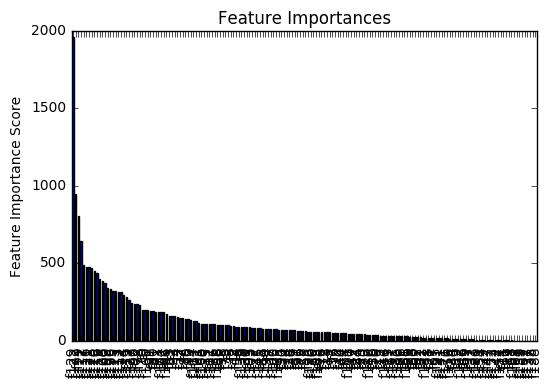

In [15]:
import matplotlib.pylab as plt
%matplotlib inline

feat_imp = pd.Series(xgb1.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')


In [ ]:
from sklearn.model_selection import RandomizedSearchCV


param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = RandomizedSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=-1, scale_pos_weight=1, seed=27), 
 param_distributions = param_test1, scoring='mean_absolute_error',n_jobs=12,iid=False, cv=5,verbose = 5)
gsearch1.fit(X_train,np.log(y_train))
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Process PoolWorker-21:
Process PoolWorker-20:
Process PoolWorker-13:
Process PoolWorker-14:
Process PoolWorker-22:
Process PoolWorker-15:
Process PoolWorker-23:
Process PoolWorker-16:
Process PoolWorker-19:
Process PoolWorker-18:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-24:
Process PoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib64/python2.7/multiprocessing/process.py", 

In [1]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

NameError: name 'gsearch1' is not defined

In [20]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss
from sklearn import preprocessing

import numpy as np
import pandas as pd

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import sys
# The path to XGBoost wrappers goes here
# sys.path.append('C:\\Users\\Amine\\Documents\\GitHub\\xgboost\\wrapper')
import xgboost as xgb

def score(params):
    print "Training with params : "
    print params
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=np.log(y_train))
    dvalid = xgb.DMatrix(X_test, label=np.log(y_test))
#     watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    model = xgb.cv(params, dtrain, num_round,nfold = 5,seed = SEED)
    predictions = model.predict(dvalid)[:,1]
    score = metrics.mean_absolute_error(y_test, np.exp(predictions))
    print "\tScore {0}\n\n".format(score)
    return {'loss': score, 'status': STATUS_OK}


def optimize(trials):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 100),
             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
             'max_depth' : hp.choice('max_depth', np.arange(1, 14, dtype=int)),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             'reg_alpha' : hp.quniform('reg_alpha', 0.01, 2, 0.05),
             'eval_metric': 'mae',
             'objective': 'reg:linear',
             'nthread' : 6,
             'silent' : 1
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=250)

    print best


# X, y = load_train()
print "Splitting data into train and valid ...\n\n"
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1234)

#Trials object where the history of search will be stored
trials = Trials()

optimize(trials)

Splitting data into train and valid ...


Training with params : 
{'reg_alpha': 0.6000000000000001, 'colsample_bytree': 0.7000000000000001, 'silent': 1, 'eval_metric': 'mae', 'nthread': 6, 'min_child_weight': 4.0, 'n_estimators': 300.0, 'subsample': 0.8500000000000001, 'eta': 0.4, 'objective': 'reg:linear', 'max_depth': 4, 'gamma': 0.75}


AttributeError: 'DataFrame' object has no attribute 'predict'

In [ ]:
# MLP for Pima Indians Dataset with grid search via sklearn
import os

os.environ['KERAS_BACKEND']='theano'

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import numpy

# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
# create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, init=init, activation='relu'))
    model.add(Dense(8, init=init, activation='relu'))
    model.add(Dense(1, init=init, activation='normal'))
# Compile model
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset
# dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# # split into input (X) and output (Y) variables
# X = dataset[:,0:8]
# Y = dataset[:,8]
# create model
model = KerasRegressor(build_fn=create_model, verbose=5)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = numpy.array([50, 100, 150])
batches = numpy.array([5, 10, 20])
param_grid = dict(optimizer=optimizers, nb_epoch=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid,  scoring='mean_absolute_error',n_jobs=12,iid=False, cv=5,verbose = 5)
grid_result = grid.fit(X_train, np.log(y_train))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Using Theano backend.


Fitting 5 folds for each of 54 candidates, totalling 270 fits
